In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# dataset directory
root_dir = r'/mnt/g/textures/texture recognition/gif dataset'

In [3]:
# dataframe with name of videos
training_data = pd.DataFrame()
videos = []
tags = os.listdir(root_dir)

for dir in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, dir)

    for vid_files in os.listdir(folder_path):
        videos.append(vid_files)

training_data['videos'] = videos
print(tags)

['S005', 'S029', 'S032', 'S033', 'S045', 'S064', 'S093', 'S094', 'S097', 'S100']


## Dataset preparing

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

In [5]:
from PIL import Image

class VideoDataset(Dataset):
    ''' 
        A dataset class for handling pressure sensor data from GIF files.
            Args:
        - root_dir (str): Root directory where the dataset is stored.
        - tags (list): List of labels corresponding to each sample.
    
        Note: 
        ['S005' -> 0 , 'S007' -> 1, 'S008' -> 2, 'S010'-> 3, 'S011'-> 4, 
        'S014'-> 5, 'S016'-> 6, 'S044'-> 7, 'S054'-> 8, 'S055'-> 9]
        
        Dataset = (frames, label)
        number of frames vary for each dataset

    '''
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.video_paths = []
        self.labels = []
        self.frame_counts = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            videos = os.listdir(class_dir)
            for video in videos:
                if video.endswith('.gif'):
                    video_path = os.path.join(class_dir, video)
                    self.video_paths.append(video_path)
                    self.labels.append(label)
                    self.frame_counts.append(self.count_frames(video_path))
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = self.extract_frames(video_path)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        frames_tensor = torch.stack([torch.tensor(np.array(frame)) for frame in frames])
        label = self.labels[idx]
        return frames_tensor, label
    
    
    
    def extract_frames(self, video_path):
        frames = []
        with Image.open(video_path) as img:
            num_frames = img.n_frames
            for frame_idx in range(num_frames):
                img.seek(frame_idx)
                frame_img = img.convert('L')
                frames.append(frame_img)
        return frames
    
    def count_frames(self, video_path):
        with Image.open(video_path) as img:
            return img.n_frames


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = VideoDataset(root_dir, transform=transform)

In [13]:
a,b = dataset[0]
a.size()

torch.Size([163, 1, 224, 224])

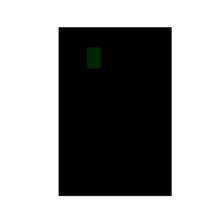

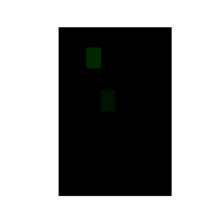

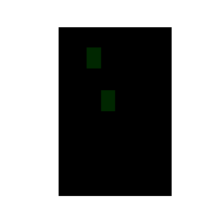

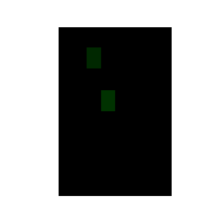

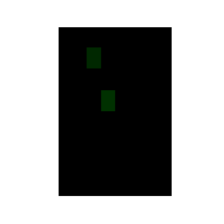

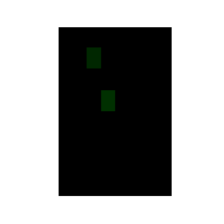

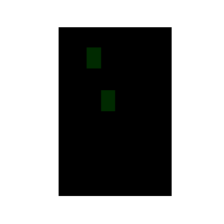

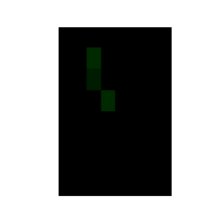

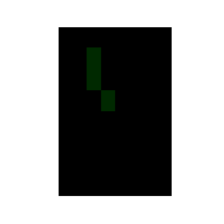

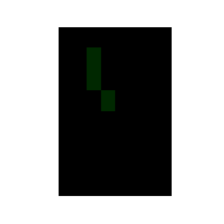

In [9]:
# checking dataset prepared

import torch
from PIL import Image
import torchvision.transforms as transforms


def visualize_frame_pil(frame_tensor):
 
    transform = transforms.ToPILImage()
    frame_pil = transform(frame_tensor)
    frame_pil.show()


for i in range(10):  # visualize the first 10 frames as an example
    visualize_frame_pil(a[i])


- Each video yeilds different number of frames
- hence trying out processing frames one by one

# CNN + LSTM model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import resnet18
from tqdm import tqdm

In [15]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTM, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 512))
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=3)
        self.fc = nn.Linear(256, num_classes)
       
    def forward(self, frames):
        batch_size, seq_len, _, _, _ = frames.size()
        hidden = None
        

        for t in range(seq_len):
            x = self.resnet(frames[:,t])  
            out, hidden = self.lstm(x.unsqueeze(0), hidden)  

        lstm_out = hidden[0][-1]

        return lstm_out


In [16]:
model = CNNLSTM(10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNLSTM(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [17]:
model.eval()

feature_vectors = []
labels = []

with torch.no_grad(), tqdm(total=len(dataset), desc='Extracting Features', unit='sample') as pbar:
    for frames, label in dataset:
        frames = frames.to(device)
        
        lstm_out = model(frames.unsqueeze(0))
        
        feature_vectors.append(lstm_out.squeeze().cpu().numpy())
        labels.append(label)
        pbar.update(1)


feature_vectors = np.array(feature_vectors)
labels = np.array(labels)

Extracting Features: 100%|██████████| 200/200 [04:13<00:00,  1.27s/sample]


Dim-Red using UMAP 

In [18]:
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import seaborn as sns


2024-06-28 12:47:29.931775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 12:47:30.975614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


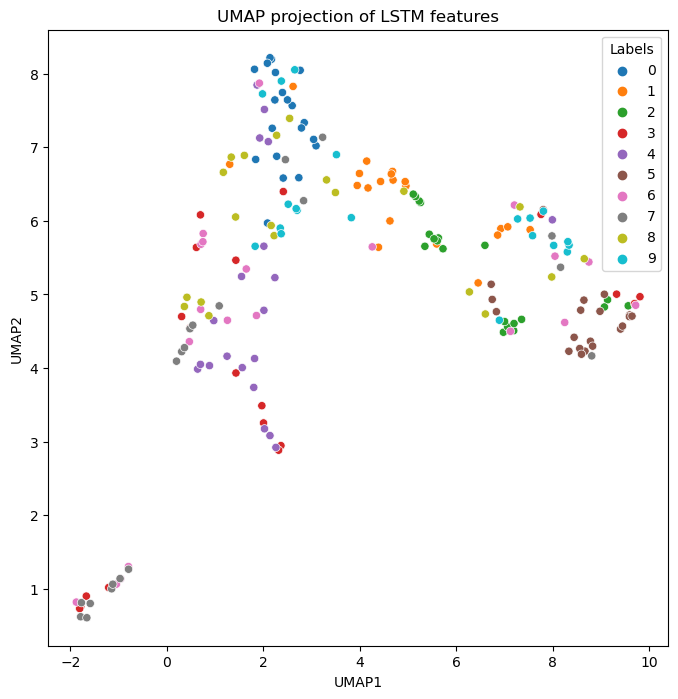

In [19]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_vectors)

umap = UMAP(n_components=2)
umap_features = umap.fit_transform(scaled_features)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=labels, palette='tab10')
plt.title('UMAP projection of LSTM features')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Labels')
plt.show()


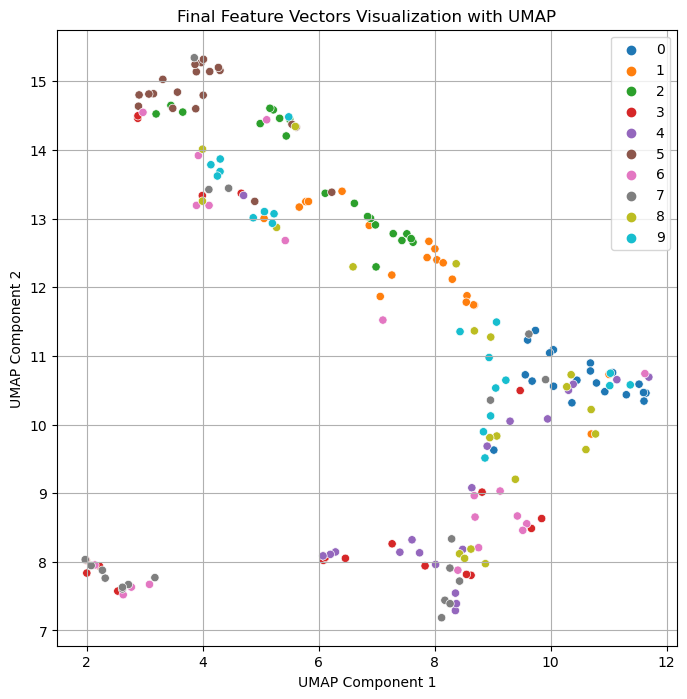

In [20]:
umap2 = UMAP(n_components=2)

new_features = umap2.fit_transform(feature_vectors)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=new_features[:, 0], y=new_features[:, 1], hue=labels, palette='tab10')
plt.title('Final Feature Vectors Visualization with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()




T-SNE

In [21]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

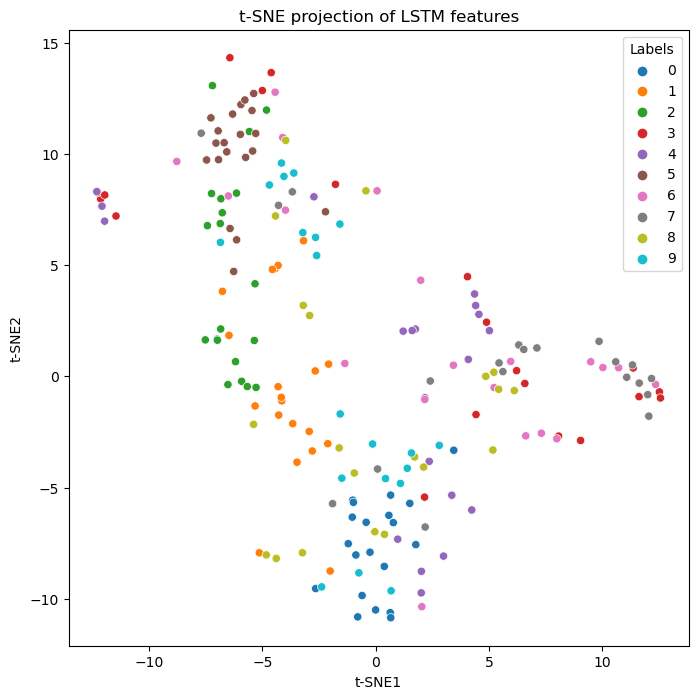

In [22]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_vectors)

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette='tab10')
plt.title('t-SNE projection of LSTM features')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend(title='Labels')
plt.show()